# Street Network Analysis: Nodes, Paths and Districts 
## Working with OSM data

In [4]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
import geopandas as gpd
%matplotlib inline

pd.set_option('precision', 5)
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

import urbanFormPy as uf

## Important: find EPSG of your case-study area
### Specify the name of the city for convenience

In [3]:
#initialise path, names, etc.

city_name = 'Torino'
epsg = 32632.
crs = {'init': 'epsg:27700', 'no_defs': True}

## Downloading the data from OpenStreetMap

1 or 2 street networks (SN) may be needed when the case study is a particular urban area (UA).

#### Option 1 ------------
Only one graph is used (*graph_A*): It includes the SN of UA and its surroundings (e.g. buffer of 2000 mt from the centre of the UA) and it is used for computing centrality measures as well as for districts identification. Paths, nodes and districts are extracted from *graph_A* by clipping them from the polygon representing UA extension. It is important to include part of the street network surrounding the UA so as to prevent the edge-effect when computing centrality measures.

#### Option 2 ------------
Two graphs are used: *graph_A* as above, plus a second one, *graph_B* even more extended than the first, for a more precise districts extraction. Paths and nodes are extracted from *graph_A*, districts from *graph_B*. 

In [5]:
# choose the method

option_1 = True
option_2 = False

### Downloading

Choose between the following methods:
* *OSMplace*, provide an OSM place name (e.g. City).
* *OSMpolygon*, provide an OSM polygon (relation) name.
* *distance_from_address*, provide a precise address and define parameter "distance" (which is otherwise not necessary)

In [ ]:
# placeMuenster = 'Münster-Mitte'
place_A = 'Temple Place, London, UK'
place_B = 'Greater London (175342)' 
download_method_graphA = 'distance_from_address'
download_method_graphB = 'OSMpolygon'

In [ ]:
if option_1:
    #graph_A  
    nodes_graphA, edes_graphA = up.get_network_fromOSM(download_method_graphA , place_A, 'walk', epsg, distance = 4000)
    print("done - Option 1")

if option_2:      
    #graph_A
    nodes_graphA, edes_graphA = up.get_network_fromOSM(download_method_graphA, place_A, 'walk', epsg, distance = 4000)

    # graph_B
    nodes_graphB, edges_graphB = up.get_network_fromOSM(download_method_graphB, place_B, 'walk', epsg)
    print("done - Option 2")

## Cleaning and simplyfing the Street Network - gdf

At the end of the previous section two files are obtained: nodes and edges (vertexes, or links). Below, before creating the actual graph, the two datasets are cleaned, simplified and corrected.

Cleaning functions handle:
* Duplicate geometries (nodes, edges).
* Pseudo-nodes.
* Disconnected islands.
* Dead-ends (optional).

In [7]:
"""""
- Turn on "update_densities" if you have flows/mobility densities or any other count associated to each edge. 
Please provide the corresponding column_name if this is the case.
- "same_uv_edges" regulates the handling of edges with same pair of u-v nodes but different geometries.
When true keeps a center line between the two segments, unless one of the two segments is significantly longer than 
the other (>30%). In this case, the longer segment is deleted.
""""
nodes_graphA, edges_graphA = up.clean_network(nodes_graphA, edges_graphA, dead_ends = True, remove_disconnected_islands = True,
                            same_uv_edges = True, update_densities = False, densities_column = None)

possible double edges 454
possible double edges 264
possible double edges 72
possible double edges 25
possible double edges 6
possible double edges 2
Correcting edges coordinates..
Done
Done after  6  cycles


In [ ]:
# cleaning and simplifying large network as well
if option_2:
    nodes_graphB, edges_graphB = up.clean_network(nodes_graphB, edges_graphB, dead_ends = True, 
                                                   remove_disconnected_islands = True, same_uv_edges = True)

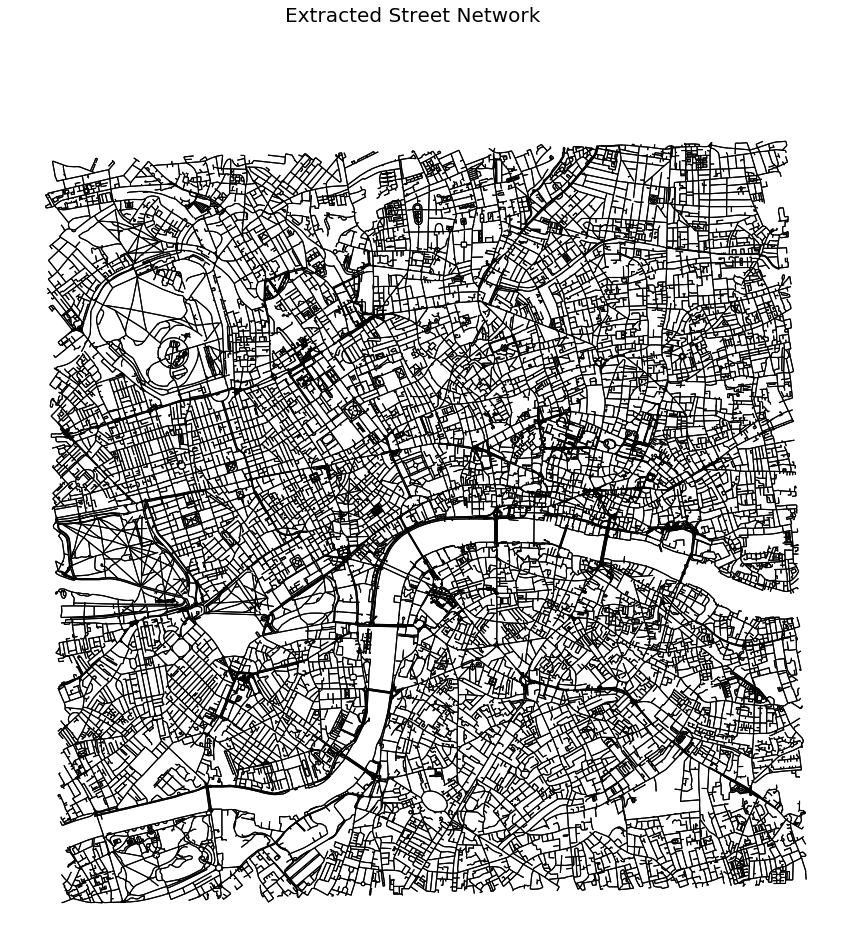

In [11]:
up.plot_lines(edges_graphA, bb = False, f = 15, title = city_name+': Extracted Street Network')

In [114]:
# obtaining graph from the case-study area 
NGs = up.graph_fromGDF(nodes_graphA, edges_graphA)

## Indexes computation - Nodes

On the primal graph representation of the street network, the following centrality measures are computed on nodes, on the basis of Euclidean distance:
* Road Distance Shortest Path Betweenness centrality (Bc_E).
* Information Centrality (Bc_Rw)
* Straightness centrality (Sc) (see [Crucitti et al. 2006](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.73.036125)).
* Reach centrality (e.g. Rc_400, Rc_600) (readataped from [Sevtsuk & Mekonnen 2012](https://www.sutd.edu.sg/cmsresource/idc/papers/2012_Urban_Network_Analysis_A%20New%20Toolbox_for_ArcGIS.pdf)) - it measures the importance of a node based on the number of services (e.g. commercial activities) reachable by that node (for instance within a buffer).
* Local Road Distance Shortest Path Betweenness centrality (e.g. Bc_E_400, Bc_E_600 ). Global Betweenness centrality values are simply rescaled within a buffer (e.g., 400 and 600 meters radii)

The first measure (*Bc_E*) is here used to identify Lynchian nodes.

### Centrality measures

In [230]:
"""
"measure" accepts "betweenness_centrality", "information_centrality", "straightness_centrality", "closeness_centrality".
The function returns dictionaries, which are going to be merged in the GDF below.
"""
# betweenness centrality
Bc_Eu = up.centrality(NGs, measure = "betweenness_centrality", weight = 'length', normalized = False)
# information centrality
Bc_Rw =  up.centrality(NGs, measure = "information_centrality", weight = 'length', normalized = False)
# straightness centrality
Sc = up.centrality(NGs, measure = "straightness_centrality", weight = 'length', normalized = False)

In [ ]:
# straightness centrality
# Sc = up.straightness_centrality(NGs, weight = 'length', normalized=False)

### Choose which of the following amenities you consider relevant as "services" for computing reach centrlality. Check [OSM amenities](https://wiki.openstreetmap.org/wiki/Key:amenity) for details

In [14]:
amenities = ['arts_centre', 'atm', 'bank', 'bar', 'bbq', 'bicycle_rental', 'bicycle_repair_station', 'biergarten', 
             'boat_rental', 'boat_sharing', 'brothel', 'bureau_de_change', 'cafe', 'car_rental', 'car_sharing', 'car_wash', 'casino', 'childcare',
           'cinema', 'clinic', 'college', 'community_centre', 'courthouse', 'crematorium', 'dentist', 'dive_centre', 'doctors', 
           'driving_school', 'embassy', 'fast_food', 'ferry_terminal', 'fire_station', 'food_court', 'fuel', 'gambling', 'gym', 
           'hospital', 'ice_cream', 'internet_cafe', 'kindergarten', 'kitchen', 'language_school', 'library', 'marketplace', 
           'monastery', 'motorcycle_parking', 'music_school', 'nightclub', 'nursing_home', 'pharmacy', 'place_of_worship', 
           'planetarium', 'police', 'post_office', 'prison', 'pub', 'public_building', 'ranger_station', 'restaurant', 'sauna',
           'school', 'shelter', 'shower', 'social_centre', 'social_facility', 'stripclub', 'studio', 'swingerclub', 'theatre', 
           'toilets', 'townhall', 'university', 'veterinary']

In [ ]:
# reach centrality pre-computation, in relation to Point of Interests or any other point-geodataframes 
services = ox.pois.pois_from_address(placeA, distance = 4000, amenities=amenities).to_crs(epsg=epsg)

# using a 50 mt buffer
NGs = up.weight_nodes(nodes_graphA, services, NGs, buffer = 50, name = 'services')
      
# Reach Centrality
Rc400 = up.reach_centrality(NGs, weight = 'length', radius = 400, attribute = 'services') 
Rc600 = up.reach_centrality(NGs, weight = 'length', radius = 600, attribute = 'services')

In [265]:
col = [Bc_Eu, Bc_Rw, Sc, Rc400, Rc600]
names = ['Bc_E', 'Bc_Rw', 'Sc', 'Rc400', 'Rc600']
nodes_df = up.dict_to_df(col, names)
nodes_graphA = pd.merge(nodes, nodes_df, left_on = "nodeID", right_index = True, how = 'left')

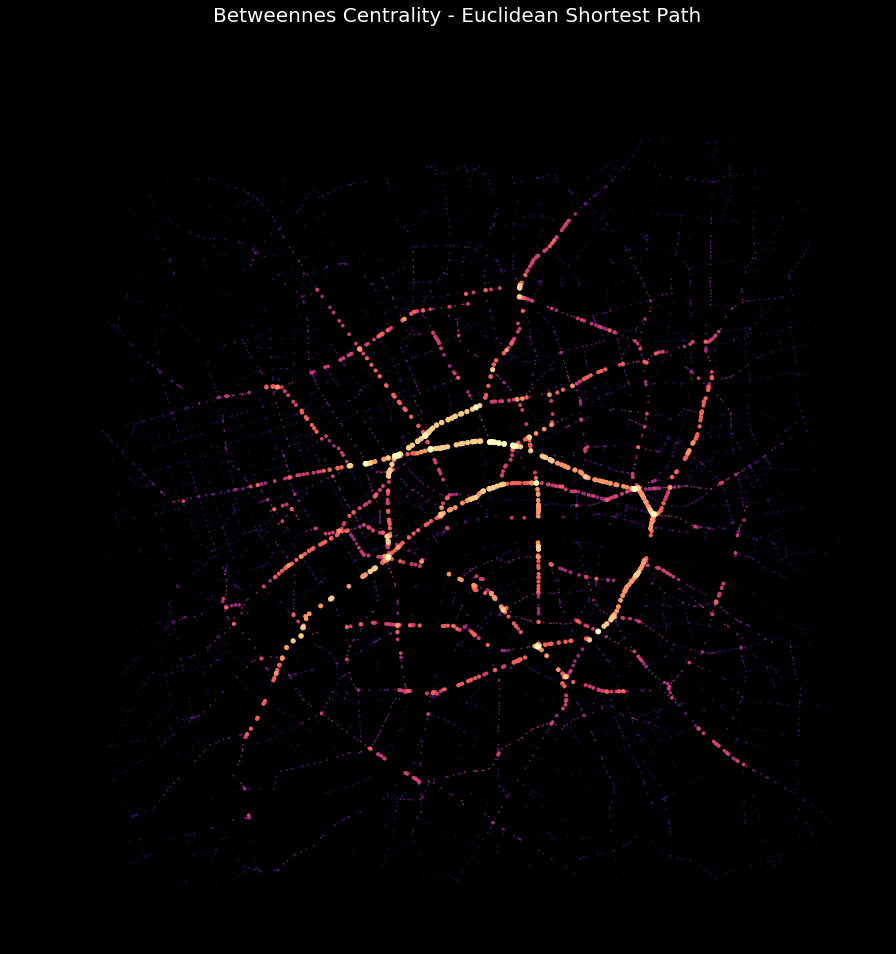

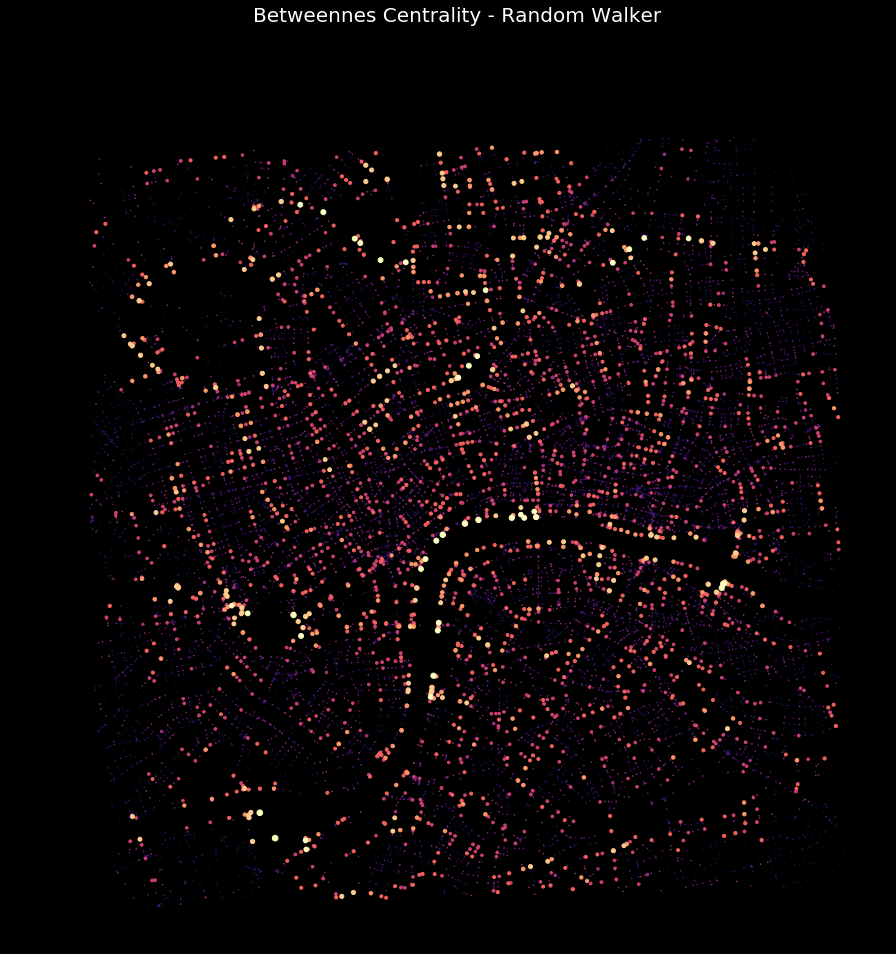

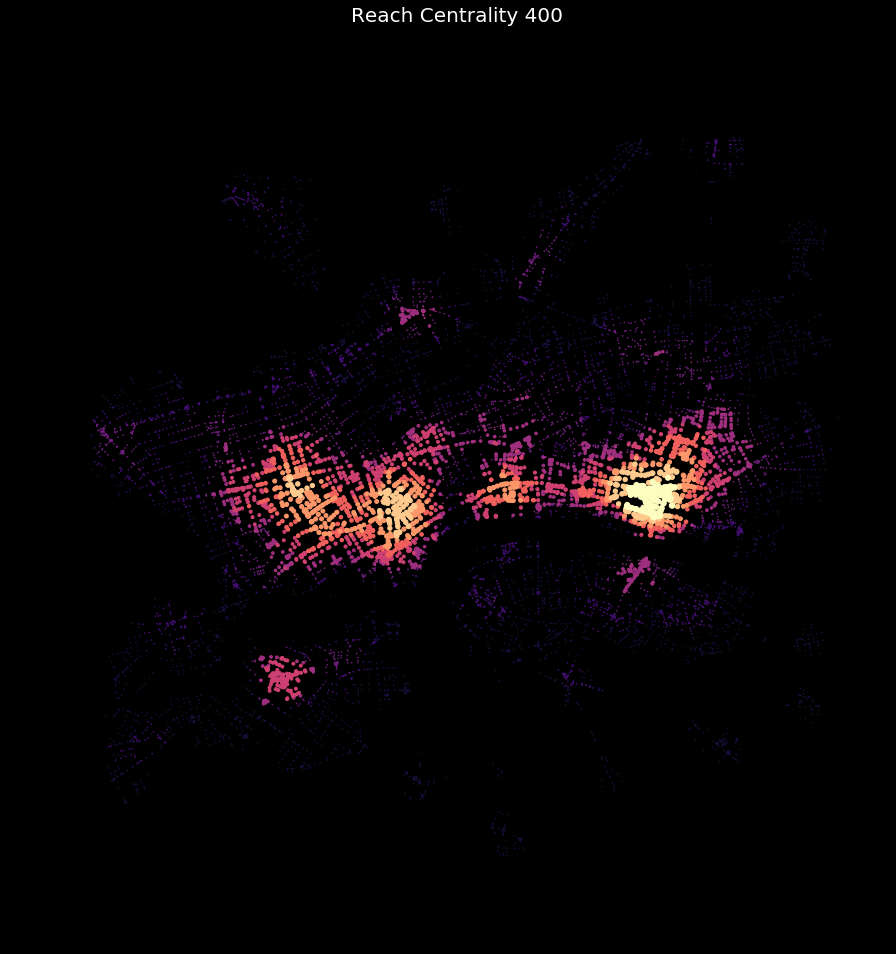

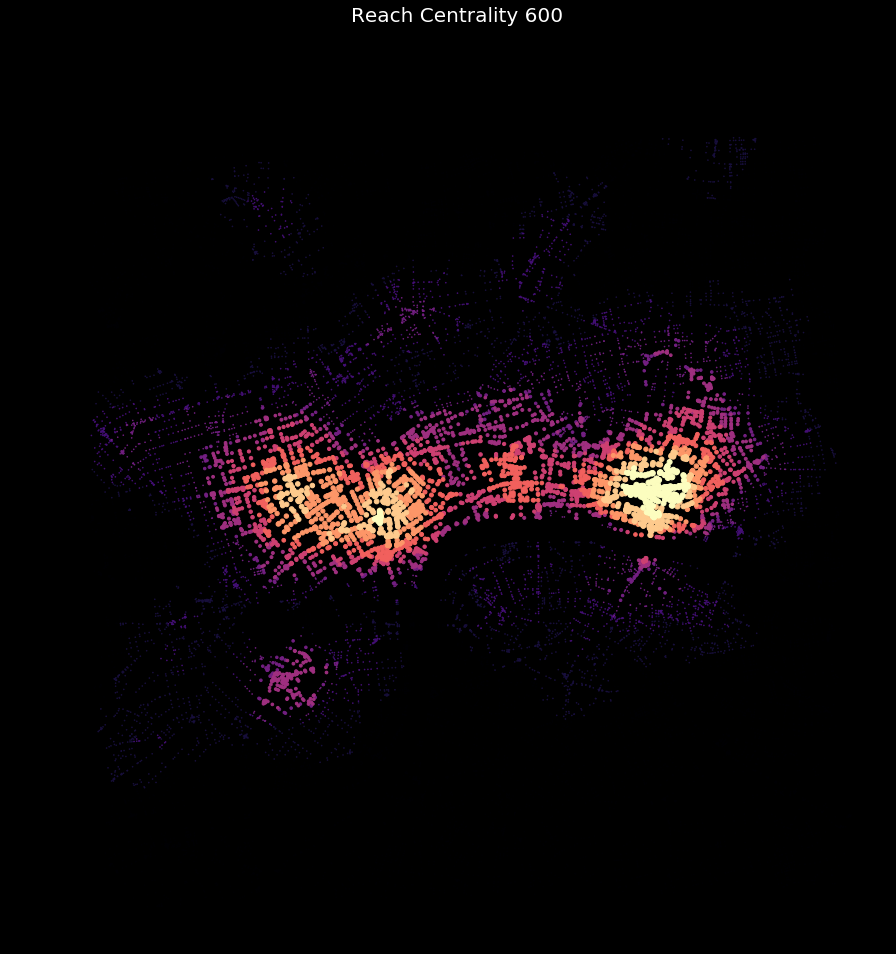

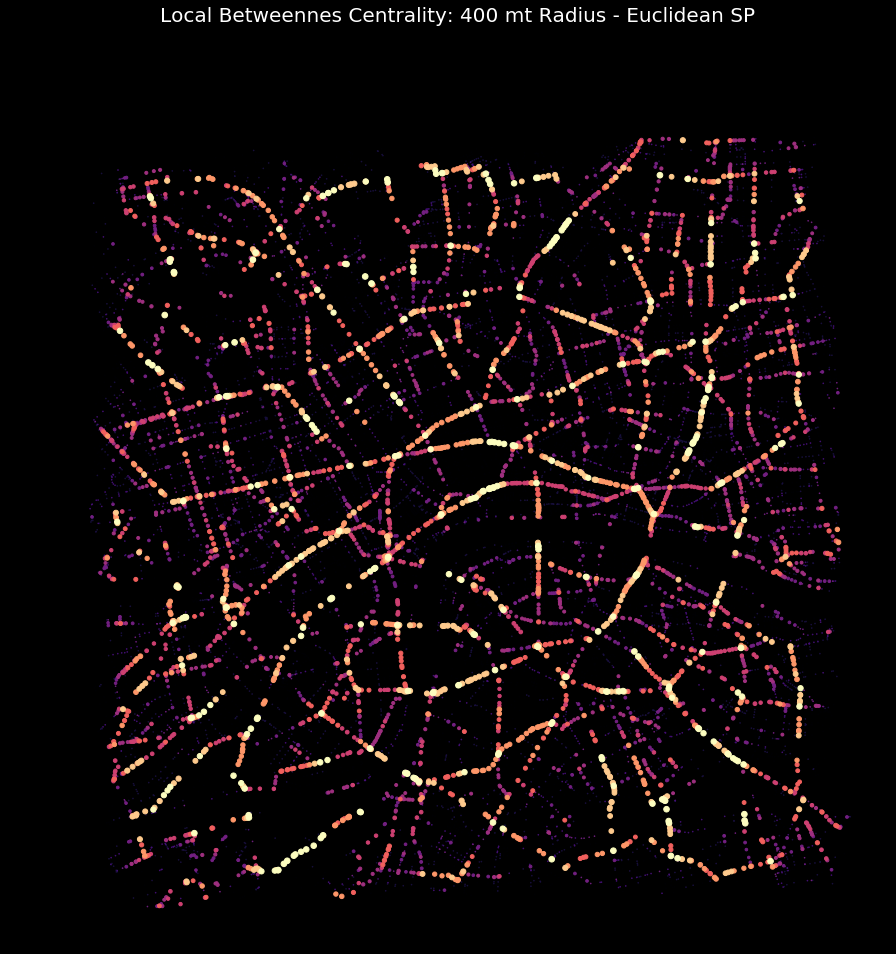

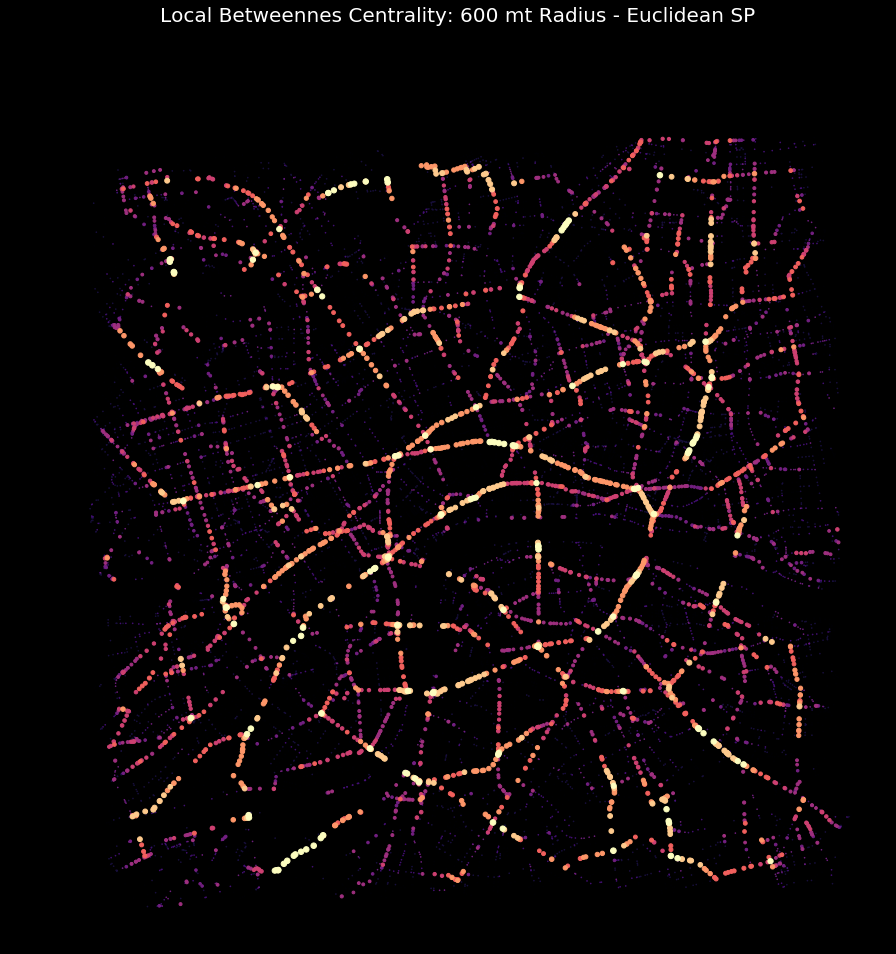

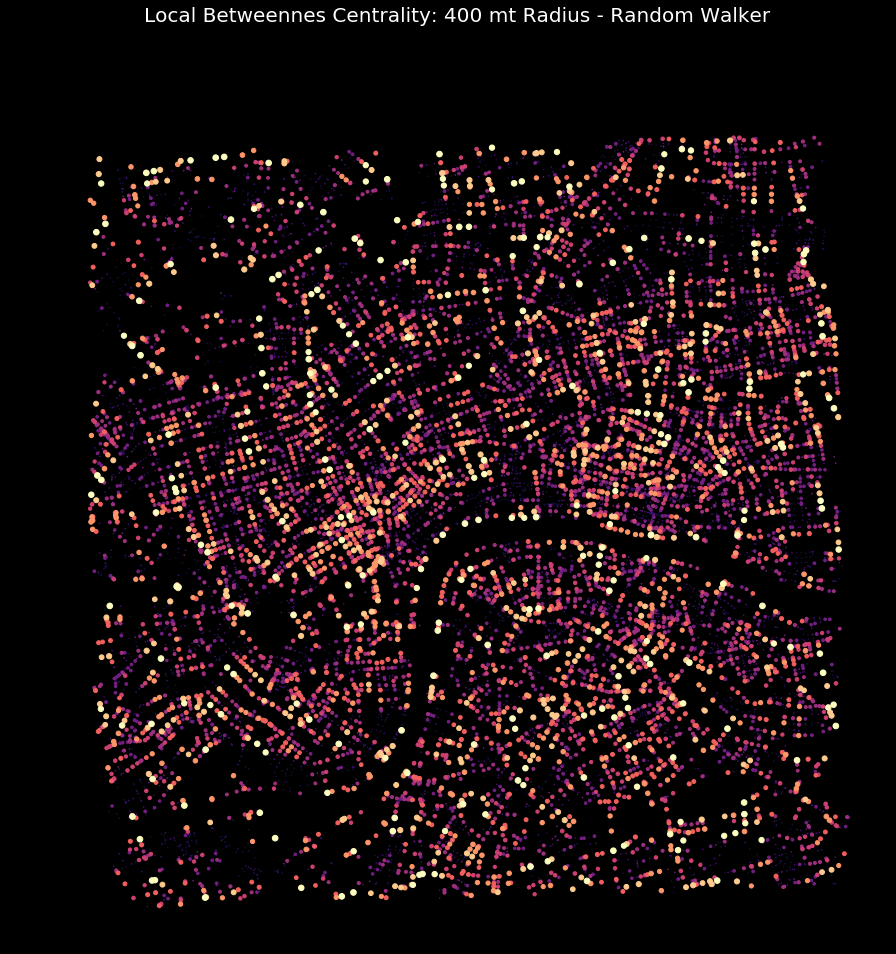

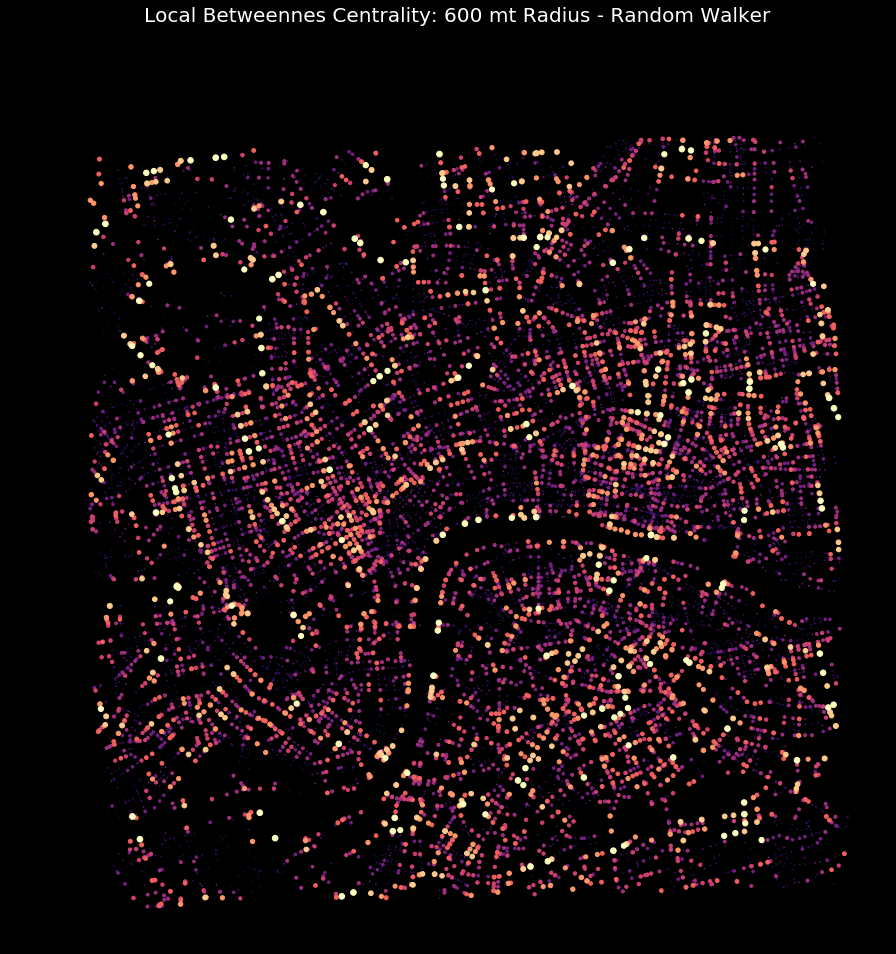

In [272]:
"""
Indicate if you want legend or color bar; colr_map, number of classes and scheme. Check the function in plotting.py for 
further parameters. You can pass the edges GeoDataFrame as the argument of "background" if you wish to have a base map 
(works with any LineString or Polygon GeoDataFrames).
"""
col = ['Bc_E', 'Bc_Rw','Sc','Rc400', 'Rc600']
title = ['Betweennes Centrality - Road Distance Shortest Path', 'Betweennes Centrality - Random Walker', 
         'Straightness Centrality', 'Reach Centrality 400', 'Reach Centrality 600']

for n, i in enumerate(col):
    tmp = nodes.copy()
    up.scaling_columnDF(tmp, i)
#     visualising by passing a series of markersize values (ms) 
    tmp['ms'] = np.where(tmp[i+'_sc'] >= 0.20, tmp[i+'_sc']*32, 0.40) # marker size
    up.plot_points(tmp, column = i, classes = 10, ms_col = 'ms', title = title[n], cmap = 'magma', f = 15)

### Local Centrality measures

In [ ]:
"""
"measure" accepts "betweenness_centrality", "straightness_centrality", "closeness_centrality".
Please provide radius. The computation may require a lot of time.
"""
Bc_400 = up.local_centrality(NGs, measure = "betweenness_centrality", weight = length, radius = 400, normalized = False)
Bc_600 = up.local_centrality(G, measure = "betweenness_centrality", weight = length, radius = 600, normalized = False)

In [273]:
# if you are interested in obtained values from 0 to 1 for the centrality measures
col = ['Bc_E', 'Bc_Rw','Rc400', 'Rc600']
for i in col: up.scaling_columnDF(nodes, i)

## Paths

On the primal graph representation of the street network, the following centrality measures are computed on edges:
* Road Distance Betweenness centrality.
* Angular Betweenness centrality (On the dual graph representation of the street network)

In [122]:
# Euclidean betweenness centrality
Eb = nx.edge_betweenness_centrality(NGs, weight = 'length', normalized = False)

In [123]:
# creating geodataframe
edgesID = {}
for i, g in NGs.edges(): edgesID[(i,g)] = NGs[i][g]['streetID']

col = [Eb, edgesID]
names = ['Eb', 'streetID']

edges_df = up.dict_to_df(col, names)
edges_df.streetID = edges_df.streetID.astype(int)
edges_tmp = pd.merge(edes_graphA, edges_df, left_on = 'streetID', right_on = 'streetID', how = 'left')

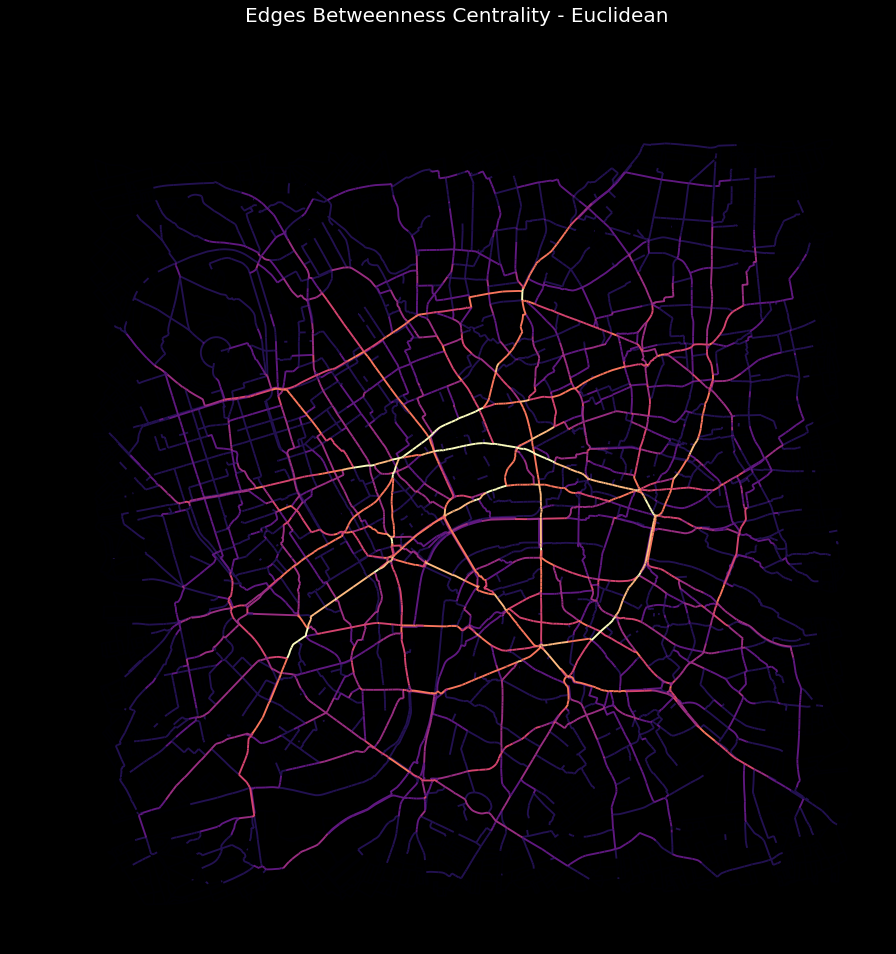

In [124]:
# visualising
up.plot_lines(edges_tmp, classes = 8, column = 'Eb', title = 'Edges Betweenness Centrality - Euclidean', lw = 1.9, 
              scheme = 'fisher_jenks', cmap = 'magma', f =15)

## Dual graph analysis

Here street-segments are transformed into nodes (geograpically represented by their centroids). Fictional links represent instead intersections. Thus if two segments are connected in the actual street network, a link in the dual graph representation will be created by connecting the corresponding nodes. 
This process allows to take advantage of angular relationships in centrality measures computation and other network operations.

In [208]:
# Creating the dual geodataframes and the dual graph.
nodesDual_graphA, edgesDual_graphA = up.dual_gdf(nodes_graphA, edges_graphA, crs)
DGa = up.get_dual_graph(nodesDual_graphA, edgesDual_graphA)

## Angular Betweenness - Paths

In [210]:
# Angular-change betweenness centrality
Ab = nx.betweenness_centrality(DGa, weight = 'rad', normalized = False)
Ab_dict = up.dual_id_dict(Ab, DGa, 'streetID')
Ab_df = up.dict_to_df([Ab_dict], ['Ab'])
edges = pd.merge(edges_tmp, Ab_df, left_on = "streetID", right_index = True, how = 'left')

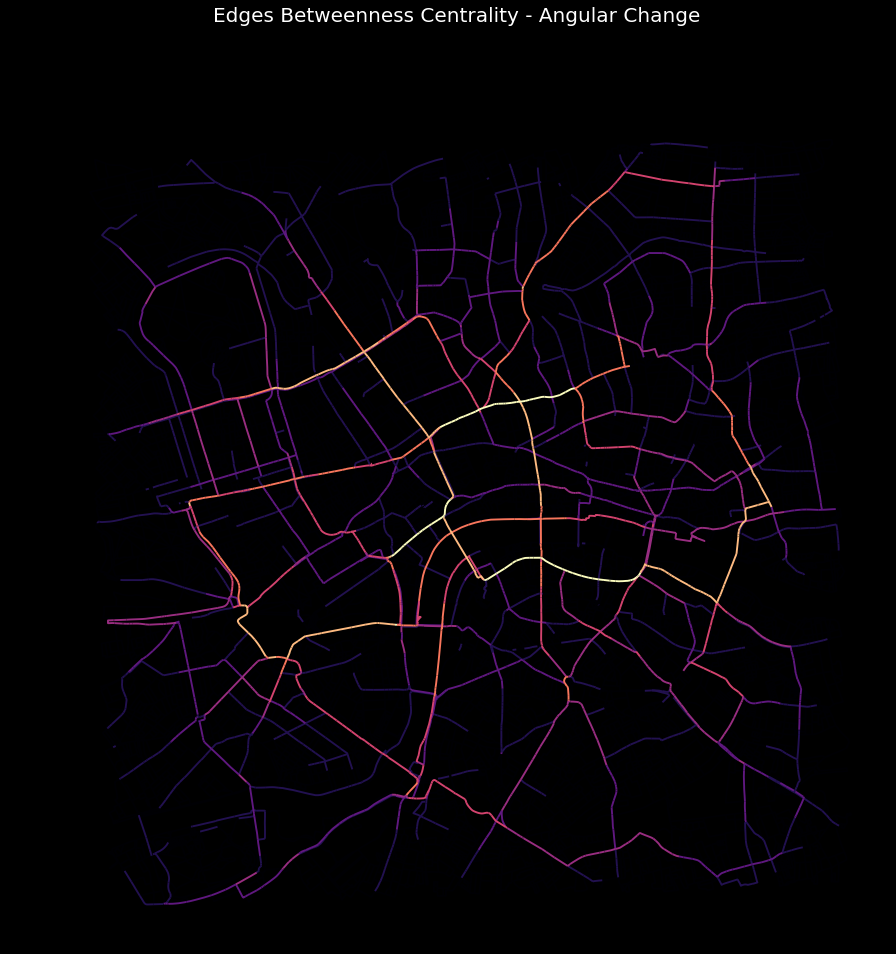

In [211]:
up.plot_lines(edges, classes = 8, column = 'Ab', title = 'Edges Betweenness Centrality - Angular Change', lw = 1.9, cmap = 'magma', 
              scheme = 'fisher_jenks', f = 15)

## Districts

Finally, districts are extracted using the Modularity Optimisation Algorithm.

In [ ]:
# specify which graph shall be used for the district identification
if option_1: 
    DGb = DGa
    edges_graphB = edges_graphA
else: 
    nodesDual_graphB, edgesDual_graphB = up.dual_gdf(nodes_graphB, edges_graphB, crs)
    DGb = up.get_dual_graph(nodesDual_graphB, edgesDual_graphB)

In [157]:
"""
Different weights are used to extract the partitions. "None" indicates that no weights will be used 
(only topological relationships will matter). The function returns a GeoDataFrame with partitions assigned to edges,
with column named as "p_name_weight" (e.g. "p_length")
 
"""
weights = ['length', 'rad', None]
for i in weights:
    districts = up.identify_regions(DGb, edges_graphB, weight = None):

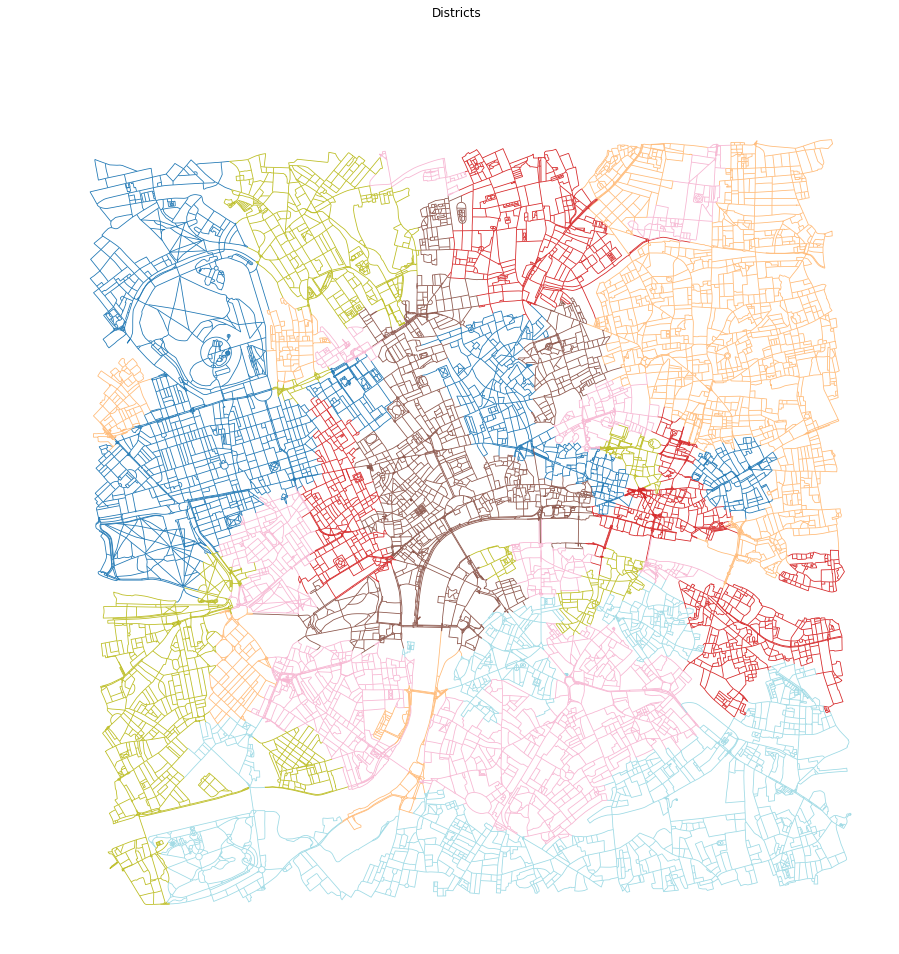

In [227]:
# visualising
up.plot_lines(districts, column = 'p_rad', title = 'Districts', lw = 0.8, cmap = 'tab20', bb = False, legend = False, f =15)

## Natural Roads

Finally, before saving, street segments are categorised based on the continuing roads or natural roads approach.
Streets are indeed recognised as entities by an observer in relation to the perception of continuity - a concept adressed already by Lynch himself - rather than for their name.
Continuity is based indeed on the degree of angular change amplitude (continuity tolerance is defined through the tolerance parameter; two segments are never considered continuous if their angle of incidentce is higher than the tolerance).

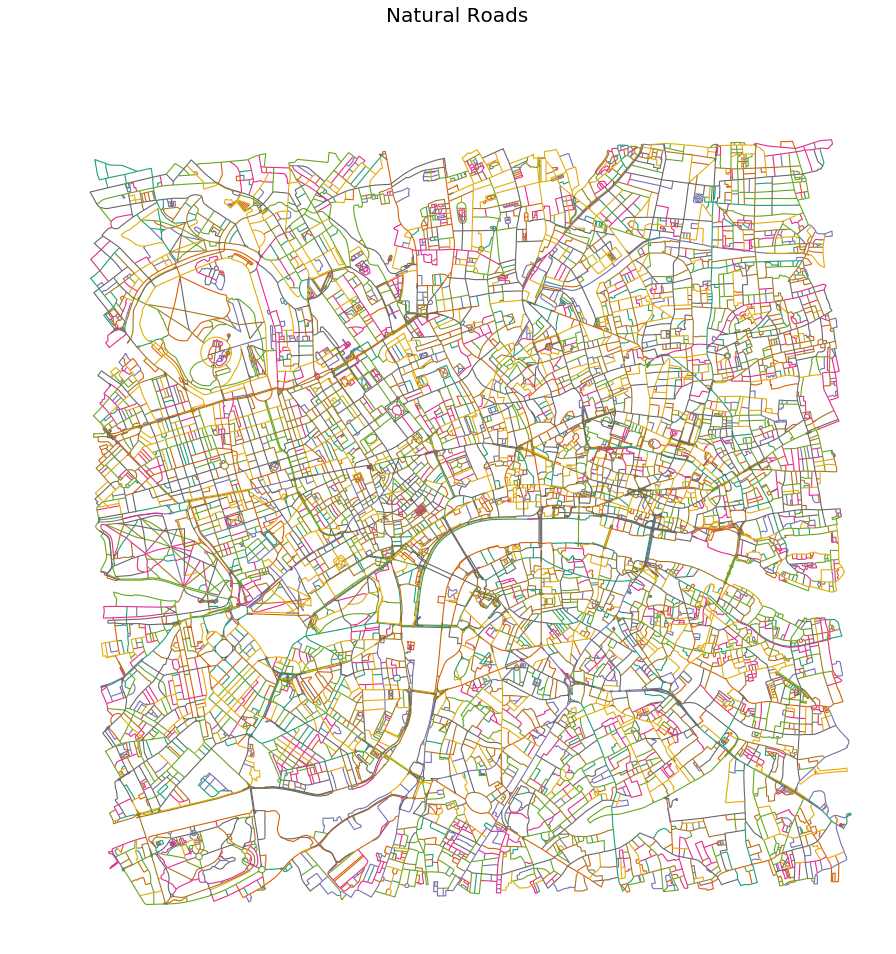

In [216]:
# running natural roads_functions 
edges = up.identify_natural_roads(nodes, edges, tolerance = 45)
# and visualising
up.plot_lines(edges, column = 'naturalID', title = 'Natural Roads', lw = 1.1, cmap = 'Dark2', bb = False, 
              legend = False, f = 15)

## Saving graphs

In [ ]:
# provide path
saving_path = None

In [ ]:
nodes.crs = crs
nodes.to_file(saving_path+city_name+'_nodes.shp', driver='ESRI Shapefile')
edges.crs = crs
edges.to_file(saving_path+city_name+'_edges.shp', driver ='ESRI Shapefile')

nodesDual_graphA = nodesDual_graphA.drop('intersecting', axis=1)
nodesDual_graphA.crs = crs
nodesDual_graphA.to_file(saving_path+city_name+'_nodesDual.shp', driver = 'ESRI Shapefile')
edgesDual_graphA.crs = crs
edgesDual_graphA.to_file(saving_path+city_name+'_edgesDual.shp', driver = 'ESRI Shapefile')

In [272]:
# saving districts
districts.crs = crs
districts.to_file(saving_path+city_name+'_districts.shp', driver = 'ESRI Shapefile')